# Health Insurance fraud detection using Medicare Providers dataset


In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib
import os
from pathlib import Path
%matplotlib inline

In [2]:
#Change directory to root
path = Path(os.getcwd())
root_dir = path.parent.absolute()
os.chdir(str(root_dir))

## 2. Data cleaning

In [3]:
df = pd.read_csv('data\processed\CMS_Provider(2016_2019).csv',low_memory=False)

In [4]:
df.shape

(4419977, 14)

### Type checking

In [5]:
df.dtypes

Rndrng_NPI                     int64
Rndrng_Prvdr_Type             object
Rndrng_Prvdr_State_Abrvtn     object
Rndrng_Prvdr_Gndr             object
Tot_HCPCS_Cds                  int64
Bene_Male_Cnt                float64
Bene_Avg_Age                   int64
Tot_Srvcs                    float64
Tot_Benes                      int64
Bene_Avg_Risk_Scre           float64
Tot_Sbmtd_Chrg               float64
Tot_Mdcr_Pymt_Amt            float64
year                           int64
Fraud                          int64
dtype: object

### Unique values

In [6]:
df.nunique()

Rndrng_NPI                   1342589
Rndrng_Prvdr_Type                102
Rndrng_Prvdr_State_Abrvtn         61
Rndrng_Prvdr_Gndr                  2
Tot_HCPCS_Cds                    662
Bene_Male_Cnt                   6032
Bene_Avg_Age                      90
Tot_Srvcs                      96979
Tot_Benes                      10528
Bene_Avg_Risk_Scre             64245
Tot_Sbmtd_Chrg               2250857
Tot_Mdcr_Pymt_Amt            3572780
year                               4
Fraud                              2
dtype: int64

### Null values

In [7]:
df.isna().any()

Rndrng_NPI                   False
Rndrng_Prvdr_Type            False
Rndrng_Prvdr_State_Abrvtn    False
Rndrng_Prvdr_Gndr             True
Tot_HCPCS_Cds                False
Bene_Male_Cnt                 True
Bene_Avg_Age                 False
Tot_Srvcs                    False
Tot_Benes                    False
Bene_Avg_Risk_Scre           False
Tot_Sbmtd_Chrg               False
Tot_Mdcr_Pymt_Amt            False
year                         False
Fraud                        False
dtype: bool

In [8]:
dict_miss=dict()
for f in ['Rndrng_Prvdr_Gndr','Bene_Male_Cnt'] :
    dict_miss[f]=sum(df[f].isna())

In [9]:
df_miss=pd.DataFrame.from_dict(dict_miss,orient='index',columns=['Missing'])
df_miss['Missing %']=df_miss['Missing']*100/df.shape[0]
df_miss

,Missing,Missing %
Rndrng_Prvdr_Gndr,245164,5.547
Bene_Male_Cnt,489032,11.064


__5.5% of practitioner gender values are zero__

__11.064% of 'Bene_Male_Cnt' values are null__

In [10]:
df_fraud=df[df['Fraud']==1]

In [11]:
print('missing percentage (fraudulent providers):',sum(df_fraud['Rndrng_Prvdr_Gndr'].isna())/df_fraud.shape[0]*100)
print('total missing  (fraudulent providers):',sum(df_fraud['Rndrng_Prvdr_Gndr'].isna()))
print()
print('missing percentage (fraudulent providers):',sum(df_fraud['Bene_Male_Cnt'].isna())/df_fraud.shape[0]*100)
print('total missing  (fraudulent providers):',sum(df_fraud['Bene_Male_Cnt'].isna()))

missing percentage (fraudulent providers): 2.272727272727273
total missing  (fraudulent providers): 29

missing percentage (fraudulent providers): 12.304075235109718
total missing  (fraudulent providers): 157


__29 of the sex values (categorical) of fraudulent practitioners are null__

__157 of the 'Bene_Male_Cnt' values (numeric) of fraudulent practitioners are null__

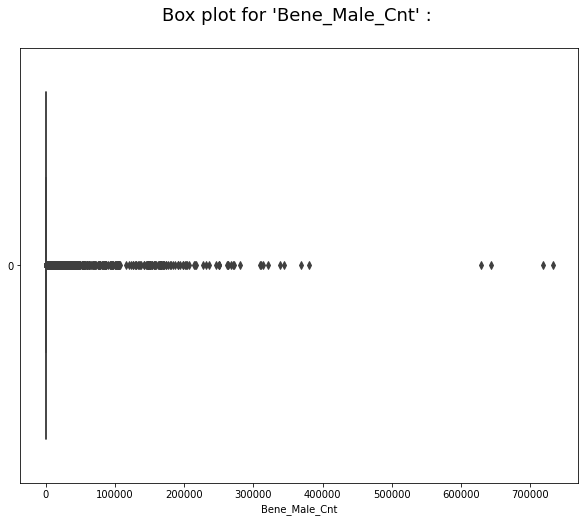

In [12]:
plt.rcParams["figure.figsize"] = (10,8)
ax32=sns.boxplot(x=df["Bene_Male_Cnt"])
ax32.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax32.set_title("Box plot for 'Bene_Male_Cnt' : \n", fontsize = "18", fontfamily = "sans-serif")
plt.show()

In [13]:
#replace 'Bene_Male_Cnt' with median (outliers presence according to Box Plot):
df['Bene_Male_Cnt'] =df['Bene_Male_Cnt'].fillna(df['Bene_Male_Cnt'].median())

In [14]:
#double check
df.isna().any()

Rndrng_NPI                   False
Rndrng_Prvdr_Type            False
Rndrng_Prvdr_State_Abrvtn    False
Rndrng_Prvdr_Gndr             True
Tot_HCPCS_Cds                False
Bene_Male_Cnt                False
Bene_Avg_Age                 False
Tot_Srvcs                    False
Tot_Benes                    False
Bene_Avg_Risk_Scre           False
Tot_Sbmtd_Chrg               False
Tot_Mdcr_Pymt_Amt            False
year                         False
Fraud                        False
dtype: bool

In [15]:
#drop missing values (sex values)
df=df.dropna()
df.isna().any()

Rndrng_NPI                   False
Rndrng_Prvdr_Type            False
Rndrng_Prvdr_State_Abrvtn    False
Rndrng_Prvdr_Gndr            False
Tot_HCPCS_Cds                False
Bene_Male_Cnt                False
Bene_Avg_Age                 False
Tot_Srvcs                    False
Tot_Benes                    False
Bene_Avg_Risk_Scre           False
Tot_Sbmtd_Chrg               False
Tot_Mdcr_Pymt_Amt            False
year                         False
Fraud                        False
dtype: bool

In [16]:
df.shape

(4174813, 14)

### Negative values

In [17]:
#check invalid values
print('Negative submitted charges :',df[df['Tot_Sbmtd_Chrg'] < 0].shape[0])
print('Negative Medicare payment :',df[df['Tot_Mdcr_Pymt_Amt'] < 0].shape[0])
print('Negative Total benefits:',df[df['Tot_Benes'] < 0].shape[0])
print('Negative Total services:',df[df['Tot_Srvcs'] < 0].shape[0])
print('Negative Total HCPCS:',df[df['Tot_HCPCS_Cds'] < 0].shape[0])
print('Negative Total Male cnt:',df[df['Bene_Male_Cnt'] < 0].shape[0])
print('Negative Average age:',df[df['Bene_Avg_Age'] <= 0].shape[0])
print('Negative Avg risk score:',df[df['Bene_Avg_Risk_Scre'] <= 0].shape[0])

Negative submitted charges : 0
Negative Medicare payment : 0
Negative Total benefits: 0
Negative Total services: 0
Negative Total HCPCS: 0
Negative Total Male cnt: 0
Negative Average age: 0
Negative Avg risk score: 0


### Duplicate values

In [18]:
#check without considering NPI & year
dups=df[df.duplicated(list(f for f in df.columns if f!= 'Rndrng_NPI' and f!= 'year' ))] 

In [19]:
print('Duplicated rows : ',dups.shape[0])

Duplicated rows :  0


### Saving dataframe

In [20]:
# saving clean dataframe as CSV
df.to_csv("data\processed\Clean_CMS_Provider(2016_2019).csv",index=False)